In [1]:
import tensorflow as tf
import transformers
import keras
from keras.models import Model

In [2]:
from tensorflow.data import Dataset
from tensorflow import keras
from collections import Counter
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, smart_resize
from PIL import ImageFile

In [3]:
import torch
import numpy as np
import tensorflow as tf
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
VIDEO_PATH = "/kaggle/input/unber-1111/UNBER-1k/Extracted_Frames"  # Path for video frames
AUDIO_PATH = "/kaggle/input/unber-1111/UNBER-1k/Audios"  # Path for audio files
TEXT_CSV = "/kaggle/input/unber-1111/UNBER-1k/text.csv"

In [5]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [6]:
tdf['Visual texts'] = tdf['Visual texts'].fillna("কোন টেক্সট পাওয়া যায়নি")

In [7]:
tdf.head()

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie
1,www.facebook.com/reel/1006146964533997,Safe,কোন টেক্সট পাওয়া যায়নি
2,www.facebook.com/reel/1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love
3,www.facebook.com/reel/1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop
4,www.facebook.com/reel/1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং


In [8]:
tdf['UnsafeType'].value_counts()

UnsafeType
Safe        441
Adult       327
Harmful     221
Suicidal    122
Name: count, dtype: int64

In [9]:
tdf['UnsafeType'], uniques = pd.factorize(tdf['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [10]:
pip install noisereduce

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [12]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [13]:
def load_video_frames(folder_path):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [14]:
def process_audio_file(file_path, target_length=5, sample_rate=22050, n_mfcc=13, n_chroma=12, n_spectral_contrast=6, target_length_features=20):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Trim or pad audio to target length
    target_samples = target_length * sr
    if len(audio) > target_samples:
        audio = audio[:target_samples]  # Trim
    else:
        padding = target_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')  # Pad with silence

    # Normalize audio (zero mean, unit variance)
    mean = np.mean(audio)
    std = np.std(audio)
    safe_std = max(std, 1e-8)  # Avoid division by zero
    audio = (audio - mean) / safe_std

    # Apply noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    if not np.isfinite(reduced_noise_audio).all():
        print("Warning: Noise reduction produced NaN/Inf values, reverting to original audio.")
        reduced_noise_audio = audio  # Use original if noise reduction fails
    
    reduced_noise_audio = np.nan_to_num(reduced_noise_audio)

    # Feature Extraction
    def truncate_or_pad(feature, target_length_features):
        """Ensures features have a fixed length by truncating or padding."""
        if feature.shape[1] > target_length_features:
            return feature[:, :target_length_features]
        else:
            return np.pad(feature, ((0, 0), (0, target_length_features - feature.shape[1])), mode='constant')

    # Extract MFCCs (13 coefficients)
    mfcc = librosa.feature.mfcc(y=reduced_noise_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = truncate_or_pad(mfcc, target_length_features)

    # Extract Chroma Features (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=reduced_noise_audio, sr=sr, n_chroma=n_chroma)
    chroma = truncate_or_pad(chroma, target_length_features)

    # Extract Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=reduced_noise_audio, sr=sr)
    spectral_centroid = truncate_or_pad(spectral_centroid, target_length_features)

    # Extract Spectral Contrast (6 bands)
    spectral_contrast = librosa.feature.spectral_contrast(y=reduced_noise_audio, sr=sr, n_bands=n_spectral_contrast)
    spectral_contrast = truncate_or_pad(spectral_contrast, target_length_features)

    # Extract Spectrogram (Magnitude Spectrogram)
    spectrogram = np.abs(librosa.stft(reduced_noise_audio))
    spectrogram = truncate_or_pad(spectrogram, target_length_features)

    # Flatten all features into a single vector
    feature_vector = np.concatenate([
        mfcc.flatten(),
        chroma.flatten(),
        spectral_centroid.flatten(),
        spectral_contrast.flatten(),
        spectrogram.flatten()
    ])

    return feature_vector

In [15]:
X_video, X_audio, X_text, y = [], [], [], []

In [16]:
for _, row in tdf.iterrows():
    reel_id = row["reel_id"].split("/")[-1]  
    label = row["UnsafeType"]  

    video_folder = os.path.join(VIDEO_PATH, reel_id)
    audio_file = os.path.join(AUDIO_PATH, f"audio{reel_id}.wav")

    if os.path.isdir(video_folder) and os.path.exists(audio_file):
        frames = load_video_frames(video_folder)  
        processed_audio = process_audio_file(audio_file)  
        text_feature = row["Visual texts"]  

        X_video.append(frames)
        X_audio.append(processed_audio)
        X_text.append(text_feature)
        y.append(label)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: divide by zero encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [17]:
print(len(X_video), len(X_audio), len(X_text), len(y))

1111 1111 1111 1111


In [18]:
X_video = np.array(X_video) 
X_audio = np.array(X_audio, dtype=np.float32)
X_text = np.array(X_text)  
y = np.array(y)

In [19]:
X_video.shape

(1111, 5, 224, 224, 3)

In [20]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler()

# # Scale X_video, X_audio, and X_text
# X_video_scaled = scaler.fit_transform(X_video.reshape(X_video.shape[0], -1))  # Flatten video frames
# X_audio_scaled = scaler.fit_transform(X_audio.reshape(X_audio.shape[0], -1))  # Flatten audio features

In [21]:
X_video = X_video.reshape(-1, 224, 224, 3)
X_audio = np.repeat(X_audio, 5, axis=0)
X_text = np.repeat(X_text, 5, axis=0)
y = np.repeat(y, 5, axis=0)

In [22]:
X_video.shape

(5555, 224, 224, 3)

In [23]:
X_audio.shape 

(5555, 21160)

In [24]:
X_audio = np.expand_dims(X_audio, axis=-1)

In [25]:
X_audio.shape

(5555, 21160, 1)

In [26]:
X_text.shape

(5555,)

In [27]:
y.shape 

(5555,)

In [28]:
# Step 1: Split into train and temp (val + test)
X_train_vid, X_temp_vid, X_train_aud, X_temp_aud, X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X_video, X_audio, X_text, y, test_size=0.2, random_state=42, shuffle=True
)

# Step 2: Split temp into val and test
X_val_vid, X_test_vid, X_val_aud, X_test_aud, X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_vid, X_temp_aud, X_temp_text, y_temp, test_size=0.5, random_state=42, shuffle=True
)

## Text Preprocessing

In [29]:
model_name = "csebuetnlp/banglabert"

In [30]:
from transformers import AutoModelForPreTraining, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
train_encodings = tokenizer(list(X_train_text), max_length=512, truncation=True, padding="max_length", return_tensors='tf')
print(np.shape(train_encodings["input_ids"]))

val_encodings = tokenizer(list(X_val_text), max_length=512, truncation=True, padding="max_length", return_tensors='tf')
print(np.shape(val_encodings["input_ids"]))

test_encodings = tokenizer(list(X_test_text), max_length=512, truncation=True, padding="max_length", return_tensors='tf')
print(np.shape(test_encodings["input_ids"]))

(4444, 512)
(555, 512)
(556, 512)


## Audio Preprocessing

In [32]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define Autoencoder (512-D encoded representation)
def build_audio_autoencoder(input_dim=21160, latent_dim=512):
    input_audio = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(256, activation='relu')(input_audio)
    encoded = Dense(latent_dim, activation='relu')(encoded)  # Compressed 512-D representation

    # Decoder
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Reconstruct original input

    autoencoder = Model(input_audio, decoded)
    encoder = Model(input_audio, encoded)  # This will be used for fusion

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Create the autoencoder
autoencoder, audio_encoder = build_audio_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21160)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,417,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21160)               │       5,438,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,118,248 (42.41 MB)

 Trainable params: 11,118,248 (42.41 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Train the Autoencoder
autoencoder.fit(
    X_train_aud, X_train_aud,
    epochs=100, batch_size=16, shuffle=True,
    validation_data=(X_val_aud, X_val_aud),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 9167.8564 - val_loss: 8826.8984 - learning_rate: 0.0010
Epoch 2/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9195.0557 - val_loss: 8826.9707 - learning_rate: 0.0010
Epoch 3/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9502.7021 - val_loss: 8827.0127 - learning_rate: 0.0010
Epoch 4/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9467.8369 - val_loss: 8827.0371 - learning_rate: 0.0010
Epoch 5/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9099.6191 - val_loss: 8827.0820 - learning_rate: 0.0010
Epoch 6/100
270/278 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9427.4961
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9423.7354 - val_loss: 8827.0957 - learning_rate: 0.0010
Epoch 7/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8991.4580 - val_loss: 8827.1035 - learning_rate: 5.0000e-04
Epoch 8/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 1

## Image Processing

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [35]:
def build_resnet_extractor():
    resnet = ResNet50(include_top=False, weights='imagenet', pooling='avg')  # Output: 2048-D features
    model = Model(inputs=resnet.input, outputs=resnet.output)
    return model

In [36]:
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout, GlobalAveragePooling1D, Lambda

In [37]:
resnet_extractor = build_resnet_extractor()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [38]:
X_train_vid = resnet_extractor.predict(X_train_vid)

139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step


In [39]:
X_val_vid = resnet_extractor.predict(X_val_vid)
X_test_vid = resnet_extractor.predict(X_test_vid)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step


In [40]:
X_train_aud = audio_encoder.predict(X_train_aud)  
X_val_aud = audio_encoder.predict(X_val_aud)
X_test_aud = audio_encoder.predict(X_test_aud)

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [41]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoModel

In [42]:
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
banglabert_model = AutoModel.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [43]:
def get_text_embedding(texts):
    """Extracts [CLS] embeddings for a list of texts using BanglaBERT."""
    banglabert_model.eval()  # Set model to evaluation mode
    embeddings = []

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
            outputs = banglabert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Extract [CLS] token
            embeddings.append(cls_embedding)

    return np.array(embeddings) 

In [44]:
train_emb = get_text_embedding(X_train_text) 

In [45]:
train_emb.shape

(4444, 768)

In [46]:
test_emb = get_text_embedding(X_test_text)
val_emb = get_text_embedding(X_val_text)

In [63]:
def attention_based_fusion():
    # Image Input (2048-D from ResNet)
    img_input = Input(shape=(2048,), name="image_input")

    # Audio Input (256-D from Autoencoder)
    audio_input = Input(shape=(512,), name="audio_input")

    # Precomputed Text Embeddings (768-D from BanglaBERT)
    text_input = Input(shape=(768,), name="text_input")  

    # Concatenate Features
    fused_features = Concatenate()([img_input, audio_input, text_input])

    # Fully Connected Layers
    X = BatchNormalization()(fused_features)
    X = Dense(128, activation='tanh')(X)
    X = Dropout(0.3)(X)
    X = Dense(64, activation='tanh')(X)
    X = Dense(4, activation='softmax', name="output")(X)  # Properly connected output layer

    # Define Model
    model = Model(inputs=[img_input, audio_input, text_input], outputs=X)  
    
    return model

In [64]:
model = attention_based_fusion()

In [65]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ audio_input (InputLayer)  │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 3328)           │              0 │ image_input[0][0],     │
│ (Concatenate)             │                        │                │ audio_input[0][0],     │
│                           │                        │                │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 3328)           │         13,312 │ concatenate_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │        426,112 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 4)              │            260 │ dense_9[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 447,940 (1.71 MB)

 Trainable params: 441,284 (1.68 MB)

 Non-trainable params: 6,656 (26.00 KB)

In [66]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
print(X_train_vid.shape)
print(X_train_aud.shape)
print(train_emb.shape)
print(y_train.shape)

(4444, 2048)
(4444, 512)
(4444, 768)
(4444,)


In [68]:
history = model.fit(
    x=[X_train_vid, X_train_aud, train_emb],  # Training inputs
    y=y_train,                                 # Training labels
    batch_size=32,
    epochs=20,
    validation_data=([X_val_vid, X_val_aud, val_emb], y_val),  # Validation inputs and labels
    shuffle=True
)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5179 - loss: 1.1101 - val_accuracy: 0.6126 - val_loss: 0.8588
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7492 - loss: 0.6367 - val_accuracy: 0.7712 - val_loss: 0.5676
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.5047 - val_accuracy: 0.8306 - val_loss: 0.4721
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8538 - loss: 0.3999 - val_accuracy: 0.8577 - val_loss: 0.4002
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.3386 - val_accuracy: 0.8793 - val_loss: 0.3240
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9001 - loss: 0.2809 - val_accuracy: 0.8811 - val_loss: 0.3281
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9045 - loss: 0.2543 - val_accuracy: 0.9027 - val_loss: 0.2728
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9202 - loss: 0.2215 - val_accuracy: 0

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the validation data
y_pred = model.predict(
    [X_test_vid, X_test_aud, test_emb],  # Validation inputs
    batch_size=32
)

y_pred

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


array([[5.4664469e-01, 4.4087830e-01, 1.2016151e-02, 4.6091023e-04],
       [9.9381566e-01, 3.9010197e-03, 8.8160066e-04, 1.4018180e-03],
       [9.9905032e-01, 1.9649460e-05, 9.2979515e-04, 1.8093212e-07],
       ...,
       [9.7293955e-01, 1.0234303e-02, 1.6191691e-02, 6.3453184e-04],
       [1.2753692e-03, 9.9799711e-01, 7.0007879e-04, 2.7364762e-05],
       [1.8138516e-04, 1.1844114e-04, 2.6915897e-05, 9.9967325e-01]],
      dtype=float32)

In [70]:
# If the model's output is probabilities, get the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

array([0, 0, 0, 2, 2, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0, 3, 1, 3, 1, 3, 1,
       0, 2, 2, 1, 3, 0, 0, 1, 1, 0, 0, 0, 0, 2, 3, 0, 2, 0, 0, 1, 2, 1,
       1, 0, 3, 0, 1, 2, 2, 2, 0, 1, 0, 3, 0, 2, 2, 3, 0, 2, 3, 2, 0, 1,
       0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 0, 1,
       2, 1, 1, 1, 3, 1, 0, 3, 2, 1, 1, 0, 3, 0, 0, 3, 0, 0, 0, 1, 3, 2,
       0, 3, 0, 2, 0, 1, 3, 0, 3, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2,
       1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 1, 0, 1,
       1, 2, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 1, 1, 2, 0, 0, 1, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 3, 1, 0, 2, 2, 1, 0, 0, 0, 0, 2,
       0, 0, 0, 1, 1, 0, 3, 0, 1, 0, 2, 0, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2,
       1, 0, 1, 3, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 2, 1, 2, 0,
       2, 0, 3, 3, 2, 2, 0, 2, 1, 0, 3, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 2,
       3, 0, 1, 1, 1, 3, 0, 0, 3, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 3, 0, 0,
       0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 1, 2, 0,

In [73]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       219
           1       0.89      0.90      0.90       164
           2       0.91      0.80      0.85       117
           3       0.96      0.98      0.97        56

    accuracy                           0.89       556
   macro avg       0.91      0.90      0.90       556
weighted avg       0.89      0.89      0.89       556



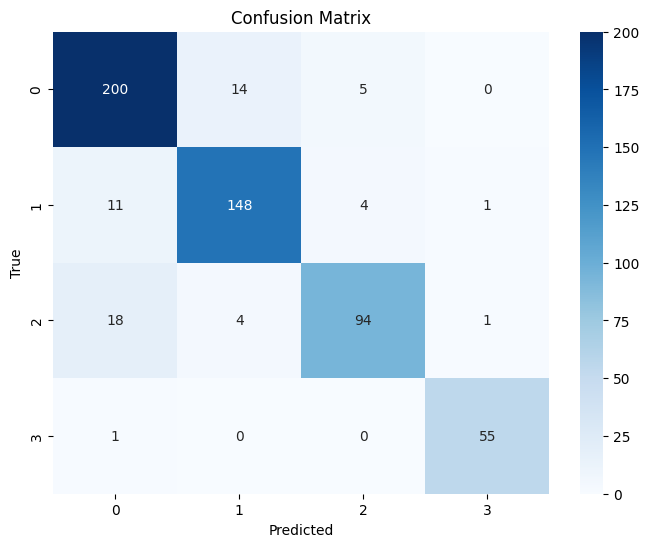

In [75]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()